In [1]:
import sys
from matplotlib import pylab
import numpy as np
from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics import constants_defaults as const
from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Singer_Ward.aerosol import AerosolAlphaPineneLight

import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning

In [2]:
ds = np.loadtxt("data/apinene_light.csv",skiprows=1,delimiter=",")
r_dry = ds[:,0]/2*1e-9
ovf = np.minimum(ds[:,1], 0.99)
d_ovf = ds[:,2]
kappa_eff = ds[:,3]
d_kappa_eff = ds[:,4]
T = 300 * si.K

datay = kappa_eff
errory = d_kappa_eff

# pylab.figure(figsize=(8,6))
# pylab.rcParams.update({'font.size':20})
# pylab.errorbar(ovf, kappa_eff, yerr=d_kappa_eff, xerr=d_ovf, fmt='ko')
# pylab.xlabel("OVF")
# pylab.ylabel("$\kappa_{eff}$")
# pylab.rcParams.update({'font.size':20})
# pylab.grid()
# pylab.show()

In [8]:
from importlib import reload
import kappa_mcmc
reload(kappa_mcmc)
from kappa_mcmc import param_transform, get_model, MCMC

c = AerosolAlphaPineneLight(ovf)

# Ovad
model = "CompressedFilmOvadnevaite"
params = [-0.2, 0.2]
stepsize = [0.1, 0.1]

# # SL
# model = "SzyszkowskiLangmuir"
# params = [20, -12.0, 3.9]
# stepsize = [0.5, 0.1, 0.05]

# # Ruehl
# model = "CompressedFilmRuehl"
# params = [16.1, -12.0, 3.5, 1.5]
# stepsize = [0.1, 0.05, 0.01, 0.05]

print(param_transform(params, model))

args = [T, r_dry, ovf, c, model]

n_steps = 5000
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=NumbaExperimentalFeatureWarning)
    param_chain, accept_chain, chi2_chain = MCMC(params, stepsize, args, datay, errory, n_steps)
#print(param_chain[:,-1])
p = param_transform(param_chain, model)
print(p[:,-1])
print(param_chain[:,-1])

[32.41195219  1.22140276]
[5.06314169 2.64498142]
[-2.58176258  0.97266404]


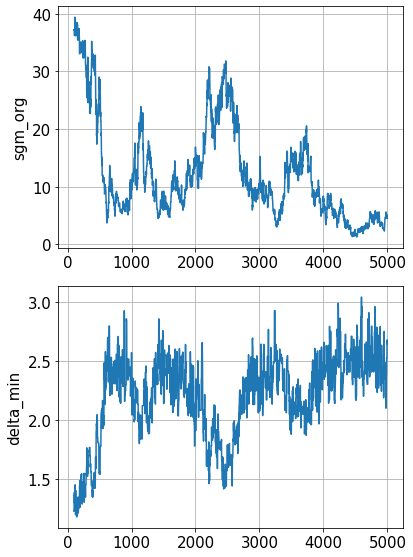

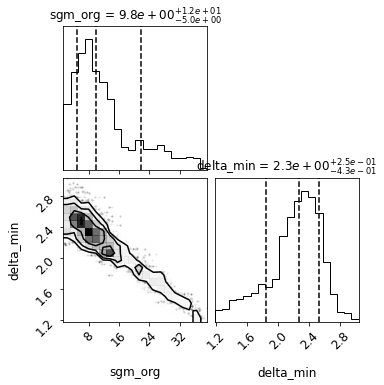

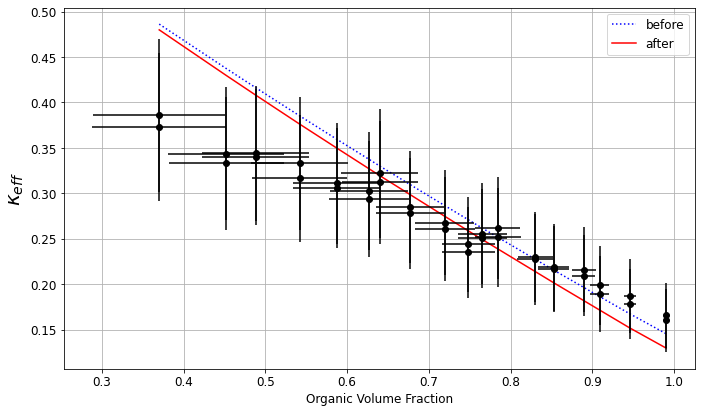

In [9]:
import mcmc_plots
reload(mcmc_plots)
from mcmc_plots import plot_param_chain, plot_corner, plot_ovf_kappa_fit, plot_keff

plot_param_chain(param_chain, args)
plot_corner(param_chain, args)
plot_ovf_kappa_fit(param_chain, args, d_ovf, datay, errory)
# plot_keff(param_chain, args, datay, errory)